<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br/social

Na aula anterior criamos nosso primeiro modelo de Deep Learning para a Previsão da Média Mensal de Vendas. Agora vamos trabalhar na otimização do modelo e começaremos com um modelo Stacked LSTM. 

**Deep Learning - O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning**

Deep Learning é uma tentativa de reproduzir nas máquinas a capacidade de inteligência humana. Logo, se aumentarmos o número de camadas do modelo e aumentarmos o número de neurônios matemáticos, nosso modelo de Deep Learning fica mais "inteligente", ou seja, mais preciso. Certo? Não necessariamente!

Sei que você não quer ouvir isso, mas a verdade precisa ser dita: Tudo depende do seu problema e do seu conjunto de dados!

Para alguns problemas, a simples adição de camadas e/ou neurônios promove um aumento significativo na precisão do modelo. Para outros casos (como o nosso), pode ser um desastre. Por isso, não use o aumento de camadas/neurônios como a sua única estratégia para tentar melhorar a performance de um modelo de Deep Learning.

Vejamos o que acontece quando criamos uma rede realmente profunda!

Esta aula considera algu conhecimento em Deep Learning e esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [2]:
# Imports para modelagem preditiva - Tensorflow 1.
#import keras
#from keras.preprocessing.sequence import TimeseriesGenerator
#from keras.models import Sequential
#from keras.layers.core import Dense, Activation
#from keras.layers import LSTM
#from keras.layers import Dropout

In [3]:
# Imports para modelagem preditiva - Tensorflow 2.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

pandas                1.0.5
seaborn               0.10.1
sklearn               0.23.1
numpy                 1.16.6
statsmodels           0.11.1
statsmodels.api       0.11.1
matplotlib            3.3.0
tensorflow_core.keras 2.2.4-tf
tensorflow            2.0.0
Data Science Academy


## Definição do Problema de Negócio

Previsão de arrecadação de ICMS.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

In [5]:
# Carrega os dados
dataframe = pd.read_csv("Arrecadacao_icms.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [6]:
# Dados
dataframe.head()

,Arrecadacao
Data,
2010-01-01,3299311
2010-02-01,2415158
2010-03-01,2613292
2010-04-01,2533679
2010-05-01,2426702


In [7]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['Arrecadacao']

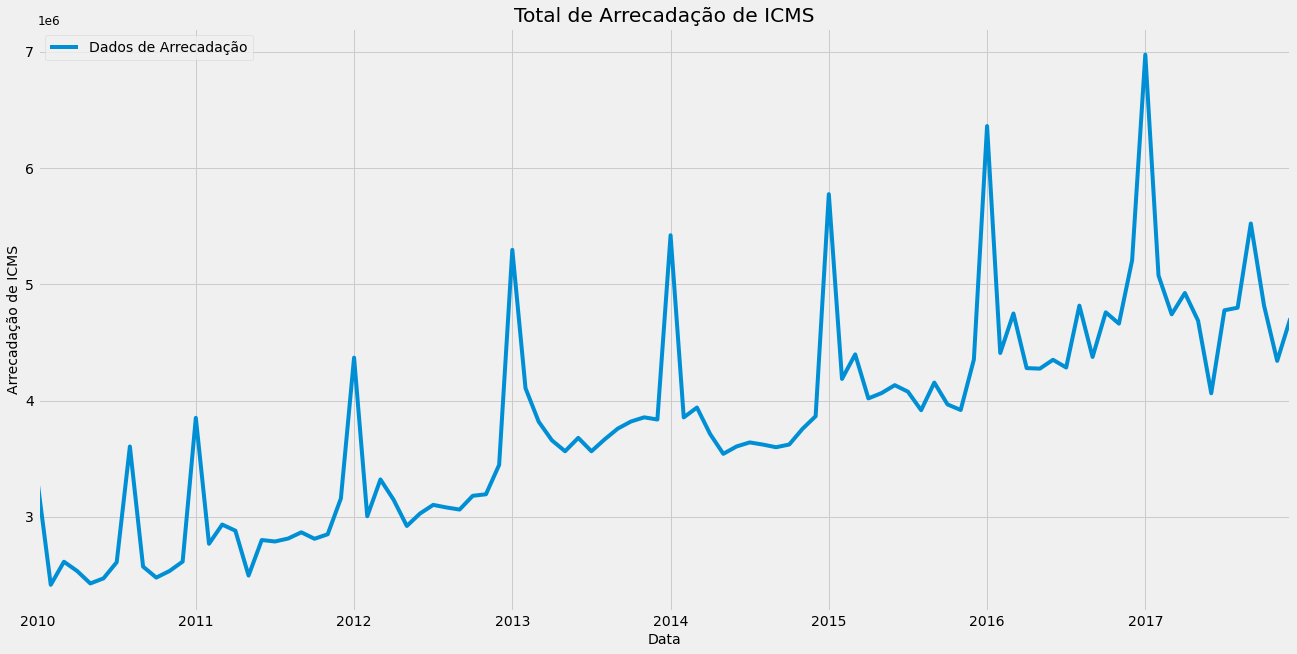

In [8]:
# Plot
target.plot(title = 'Total de Arrecadação de ICMS', fontsize = 14, label = 'Dados de Arrecadação') 
plt.xlabel("Data") 
plt.ylabel("Arrecadação de ICMS") 
plt.legend(loc = 'best') 
plt.show()

In [9]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

72 24


In [10]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.values.reshape(-1,1)
testset = teste.values.reshape(-1,1)

### Função Para o Cálculo da Acurácia

In [11]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning

Nesta aula tentaremos aumentar a precisão do nosso modelo aumentando de forma significativa o número de camadas e neurônios.

Execute o modelo e tire suas conclusões.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados.

In [12]:
# Transforma a série temporal em um problema de aprendizagem supervisionada
def timeseries_to_supervised(data, lag = 1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis = 1)
    df.fillna(0, inplace = True)
    return df

In [13]:
# Cria uma série diferenciada para tornar a série temporal estacionária
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [14]:
# Inverte valor diferenciado
def inverse_difference(history, yhat, interval = 1):
    return yhat + history[-interval]

In [15]:
# Transforma a série temporal em estacionária
raw_values = target.values
diff_values = difference(raw_values, 1)

In [16]:
# Transforma a série temporal em aprendizado supervisionado
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [17]:
# Criação do dataset de treino e teste
trainset, testset = supervised_values[0:-24], supervised_values[-24:]

In [18]:
# Normalizamos os dados aplicando scala no intervalo [-1, 1]
def scale(train, test):
    scaler = MinMaxScaler(feature_range = (-1, 1))
    scaler = scaler.fit(train)
    
    # Transforma dados de treino
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # Transforma dados de teste
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [19]:
#  Inverte a escala nas previsões para a escala original
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [20]:
# Transforma a escala dos dados
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [21]:
# Função para o modelo LSTM
def train_lstm(train, nb_epoch):
    
    # Ajusta o shape dos dados
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # Modelo
    modelo_lstm = Sequential()
    modelo_lstm.add(LSTM(200, activation = 'relu', return_sequences = True, input_shape = (1, 1)))
    modelo_lstm.add(LSTM(100, activation = 'relu', return_sequences = True))
    modelo_lstm.add(LSTM(50, activation = 'relu', return_sequences = True))
    modelo_lstm.add(LSTM(25, activation = 'relu'))
    modelo_lstm.add(Dense(20, activation = 'relu'))
    modelo_lstm.add(Dense(10, activation = 'relu'))
    modelo_lstm.add(Dense(1))
    
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

    modelo_lstm.fit(X, y, epochs = nb_epoch, verbose = 1)
    
    return modelo_lstm

> Vamos treinar por 5 mil épocas.

In [22]:
# Treinamento
start = time()

lstm_model = train_lstm(train_scaled, 5000)

print ('\nTempo gasto: %s segundos' % str(time() - start))

Train on 71 samples
Epoch 1/5000
71/71 [==============================] - 5s 69ms/sample - loss: 0.1283
Epoch 2/5000
71/71 [==============================] - 0s 697us/sample - loss: 0.1274
Epoch 3/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.1268
Epoch 4/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.1261
Epoch 5/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.1253
Epoch 6/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.1247
Epoch 7/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.1237
Epoch 8/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.1235
Epoch 9/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.1229
Epoch 10/5000
71/71 [==============================] - 0s 718us/sample - loss: 0.1225
Epoch 11/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.1224
Epoch 12/5000
71/71 [=======================

71/71 [==============================] - 0s 675us/sample - loss: 0.0699
Epoch 97/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0699
Epoch 98/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0699
Epoch 99/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0699
Epoch 100/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0698
Epoch 101/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0699
Epoch 102/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0697
Epoch 103/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0697
Epoch 104/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0698
Epoch 105/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0697
Epoch 106/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0697
Epoch 107/5000
71/71 [==============================] - 0s 60

71/71 [==============================] - 0s 633us/sample - loss: 0.0655
Epoch 285/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0651
Epoch 286/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0653
Epoch 287/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0649
Epoch 288/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0651
Epoch 289/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0648
Epoch 290/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0649
Epoch 291/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0655
Epoch 292/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0655
Epoch 293/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0651
Epoch 294/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0651
Epoch 295/5000
71/71 [==============================] - 0s

71/71 [==============================] - 0s 577us/sample - loss: 0.0645
Epoch 379/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0645
Epoch 380/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0645
Epoch 381/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0646
Epoch 382/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0644
Epoch 383/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0643
Epoch 384/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0645
Epoch 385/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0647
Epoch 386/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0647
Epoch 387/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0643
Epoch 388/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0642
Epoch 389/5000
71/71 [==============================] - 0s

71/71 [==============================] - 0s 647us/sample - loss: 0.0641
Epoch 566/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0636
Epoch 567/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0635
Epoch 568/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0639
Epoch 569/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0637
Epoch 570/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0635
Epoch 571/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0637
Epoch 572/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0638
Epoch 573/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0640
Epoch 574/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0642
Epoch 575/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0639
Epoch 576/5000
71/71 [==============================] - 0s

71/71 [==============================] - 0s 619us/sample - loss: 0.0635
Epoch 754/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0642
Epoch 755/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0635
Epoch 756/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0631
Epoch 757/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0635
Epoch 758/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0637
Epoch 759/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0635
Epoch 760/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0636
Epoch 761/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0633
Epoch 762/5000
71/71 [==============================] - 0s 689us/sample - loss: 0.0633
Epoch 763/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0630
Epoch 764/5000
71/71 [==============================] - 0s

71/71 [==============================] - 0s 647us/sample - loss: 0.0625
Epoch 941/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0626
Epoch 942/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0633
Epoch 943/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0632
Epoch 944/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0627
Epoch 945/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0623
Epoch 946/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0631
Epoch 947/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0630
Epoch 948/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0628
Epoch 949/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0622
Epoch 950/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0627
Epoch 951/5000
71/71 [==============================] - 0s

71/71 [==============================] - 0s 661us/sample - loss: 0.0622
Epoch 1127/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0621
Epoch 1128/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0619
Epoch 1129/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0618
Epoch 1130/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0615
Epoch 1131/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0616
Epoch 1132/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0616
Epoch 1133/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0616
Epoch 1134/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0614
Epoch 1135/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0612
Epoch 1136/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0613
Epoch 1137/5000
71/71 [=========================

71/71 [==============================] - 0s 633us/sample - loss: 0.0613
Epoch 1312/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0607
Epoch 1313/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0604
Epoch 1314/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0600
Epoch 1315/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0605
Epoch 1316/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0618
Epoch 1317/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0613
Epoch 1318/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0604
Epoch 1319/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0599
Epoch 1320/5000
71/71 [==============================] - ETA: 0s - loss: 0.058 - 0s 647us/sample - loss: 0.0598
Epoch 1321/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0602
Epoch 1322/5000
71/71 [=

71/71 [==============================] - 0s 633us/sample - loss: 0.0550
Epoch 1497/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0559
Epoch 1498/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0546
Epoch 1499/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0549
Epoch 1500/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0561
Epoch 1501/5000
71/71 [==============================] - ETA: 0s - loss: 0.049 - 0s 633us/sample - loss: 0.0568
Epoch 1502/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0576
Epoch 1503/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0565
Epoch 1504/5000
71/71 [==============================] - 0s 675us/sample - loss: 0.0558
Epoch 1505/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0553
Epoch 1506/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0548
Epoch 1507/5000
71/71 [=

71/71 [==============================] - 0s 633us/sample - loss: 0.0530
Epoch 1590/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0540
Epoch 1591/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0522
Epoch 1592/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0514
Epoch 1593/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0515
Epoch 1594/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0512
Epoch 1595/5000
71/71 [==============================] - 0s 577us/sample - loss: 0.0515
Epoch 1596/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0520
Epoch 1597/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0512
Epoch 1598/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0515
Epoch 1599/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0513
Epoch 1600/5000
71/71 [=========================

71/71 [==============================] - 0s 647us/sample - loss: 0.0647
Epoch 1775/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0649
Epoch 1776/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0649
Epoch 1777/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0652
Epoch 1778/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0651
Epoch 1779/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0647
Epoch 1780/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0647
Epoch 1781/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0649
Epoch 1782/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0643
Epoch 1783/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0646
Epoch 1784/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0645
Epoch 1785/5000
71/71 [=========================

71/71 [==============================] - 0s 619us/sample - loss: 0.0632
Epoch 1868/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0637
Epoch 1869/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0641
Epoch 1870/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0636
Epoch 1871/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0632
Epoch 1872/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0632
Epoch 1873/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0634
Epoch 1874/5000
71/71 [==============================] - 0s 577us/sample - loss: 0.0632
Epoch 1875/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0629
Epoch 1876/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0629
Epoch 1877/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0628
Epoch 1878/5000
71/71 [=========================

71/71 [==============================] - 0s 675us/sample - loss: 0.0643
Epoch 1961/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0626
Epoch 1962/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0624
Epoch 1963/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0646
Epoch 1964/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0643
Epoch 1965/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0633
Epoch 1966/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0629
Epoch 1967/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0628
Epoch 1968/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0630
Epoch 1969/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0641
Epoch 1970/5000
71/71 [==============================] - 0s 675us/sample - loss: 0.0641
Epoch 1971/5000
71/71 [=========================

71/71 [==============================] - 0s 619us/sample - loss: 0.0612
Epoch 2054/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0614
Epoch 2055/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0614
Epoch 2056/5000
71/71 [==============================] - 0s 577us/sample - loss: 0.0611
Epoch 2057/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0610
Epoch 2058/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0607
Epoch 2059/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0610
Epoch 2060/5000
71/71 [==============================] - 0s 577us/sample - loss: 0.0610
Epoch 2061/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0613
Epoch 2062/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0619
Epoch 2063/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0612
Epoch 2064/5000
71/71 [=========================

71/71 [==============================] - 0s 661us/sample - loss: 0.0582
Epoch 2240/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0582
Epoch 2241/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0582
Epoch 2242/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0585
Epoch 2243/5000
71/71 [==============================] - 0s 577us/sample - loss: 0.0580
Epoch 2244/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0580
Epoch 2245/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0583
Epoch 2246/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0584
Epoch 2247/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0585
Epoch 2248/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0580
Epoch 2249/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0573
Epoch 2250/5000
71/71 [=========================

71/71 [==============================] - 0s 619us/sample - loss: 0.0543
Epoch 2333/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0544
Epoch 2334/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0538
Epoch 2335/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0543
Epoch 2336/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0543
Epoch 2337/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0540
Epoch 2338/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0542
Epoch 2339/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0544
Epoch 2340/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0544
Epoch 2341/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0529
Epoch 2342/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0552
Epoch 2343/5000
71/71 [=========================

71/71 [==============================] - 0s 647us/sample - loss: 0.0524
Epoch 2518/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0521
Epoch 2519/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0529
Epoch 2520/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0509
Epoch 2521/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0512
Epoch 2522/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0528
Epoch 2523/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0530
Epoch 2524/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0515
Epoch 2525/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0518
Epoch 2526/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0515
Epoch 2527/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0506
Epoch 2528/5000
71/71 [=========================

71/71 [==============================] - 0s 619us/sample - loss: 0.0503
Epoch 2611/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0514
Epoch 2612/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0522
Epoch 2613/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0493
Epoch 2614/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0500
Epoch 2615/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0495
Epoch 2616/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0510
Epoch 2617/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0517
Epoch 2618/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0517
Epoch 2619/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0510
Epoch 2620/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0504
Epoch 2621/5000
71/71 [=========================

71/71 [==============================] - 0s 661us/sample - loss: 0.0466
Epoch 2797/5000
71/71 [==============================] - ETA: 0s - loss: 0.047 - 0s 619us/sample - loss: 0.0470
Epoch 2798/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0467
Epoch 2799/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0470
Epoch 2800/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0473
Epoch 2801/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0468
Epoch 2802/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0465
Epoch 2803/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0465
Epoch 2804/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0466
Epoch 2805/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0463
Epoch 2806/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0467
Epoch 2807/5000
71/71 [=

71/71 [==============================] - 0s 647us/sample - loss: 0.0453
Epoch 2981/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0471
Epoch 2982/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0471
Epoch 2983/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0458
Epoch 2984/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0457
Epoch 2985/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0455
Epoch 2986/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0449
Epoch 2987/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0451
Epoch 2988/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0453
Epoch 2989/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0448
Epoch 2990/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0448
Epoch 2991/5000
71/71 [=========================

71/71 [==============================] - 0s 675us/sample - loss: 0.0453
Epoch 3166/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0454
Epoch 3167/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0454
Epoch 3168/5000
71/71 [==============================] - 0s 577us/sample - loss: 0.0457
Epoch 3169/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0450
Epoch 3170/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0452
Epoch 3171/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0455
Epoch 3172/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0447
Epoch 3173/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0444
Epoch 3174/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0447
Epoch 3175/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0446
Epoch 3176/5000
71/71 [=========================

71/71 [==============================] - 0s 605us/sample - loss: 0.0448
Epoch 3351/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0456
Epoch 3352/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0453
Epoch 3353/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0461
Epoch 3354/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0456
Epoch 3355/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0447
Epoch 3356/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0448
Epoch 3357/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0439
Epoch 3358/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0458
Epoch 3359/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0443
Epoch 3360/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0440
Epoch 3361/5000
71/71 [=========================

71/71 [==============================] - 0s 619us/sample - loss: 0.0428
Epoch 3537/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0448
Epoch 3538/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0443
Epoch 3539/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0440
Epoch 3540/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0430
Epoch 3541/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0436
Epoch 3542/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0439
Epoch 3543/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0445
Epoch 3544/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0441
Epoch 3545/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0441
Epoch 3546/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0438
Epoch 3547/5000
71/71 [=========================

71/71 [==============================] - 0s 619us/sample - loss: 0.0456
Epoch 3722/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0449
Epoch 3723/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0490
Epoch 3724/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0492
Epoch 3725/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0498
Epoch 3726/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0495
Epoch 3727/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0472
Epoch 3728/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0473
Epoch 3729/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0468
Epoch 3730/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0458
Epoch 3731/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0472
Epoch 3732/5000
71/71 [=========================

71/71 [==============================] - 0s 605us/sample - loss: 0.0446
Epoch 3815/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0440
Epoch 3816/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0444
Epoch 3817/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0440
Epoch 3818/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0444
Epoch 3819/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0440
Epoch 3820/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0446
Epoch 3821/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0450
Epoch 3822/5000
71/71 [==============================] - 0s 577us/sample - loss: 0.0445
Epoch 3823/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0437
Epoch 3824/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0449
Epoch 3825/5000
71/71 [=========================

71/71 [==============================] - 0s 647us/sample - loss: 0.0443
Epoch 3908/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0437
Epoch 3909/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0438
Epoch 3910/5000
71/71 [==============================] - ETA: 0s - loss: 0.042 - 0s 619us/sample - loss: 0.0435
Epoch 3911/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0437
Epoch 3912/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0434
Epoch 3913/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0437
Epoch 3914/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0443
Epoch 3915/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0438
Epoch 3916/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0435
Epoch 3917/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0436
Epoch 3918/5000
71/71 [=

71/71 [==============================] - 0s 619us/sample - loss: 0.0452
Epoch 4093/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0441
Epoch 4094/5000
71/71 [==============================] - 0s 675us/sample - loss: 0.0441
Epoch 4095/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0446
Epoch 4096/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0444
Epoch 4097/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0445
Epoch 4098/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0447
Epoch 4099/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0442
Epoch 4100/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0444
Epoch 4101/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0448
Epoch 4102/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0446
Epoch 4103/5000
71/71 [=========================

71/71 [==============================] - 0s 633us/sample - loss: 0.0458
Epoch 4279/5000
71/71 [==============================] - 0s 675us/sample - loss: 0.0457
Epoch 4280/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0452
Epoch 4281/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0441
Epoch 4282/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0437
Epoch 4283/5000
71/71 [==============================] - 0s 577us/sample - loss: 0.0438
Epoch 4284/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0446
Epoch 4285/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0454
Epoch 4286/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0455
Epoch 4287/5000
71/71 [==============================] - 0s 661us/sample - loss: 0.0445
Epoch 4288/5000
71/71 [==============================] - 0s 577us/sample - loss: 0.0447
Epoch 4289/5000
71/71 [=========================

71/71 [==============================] - 0s 619us/sample - loss: 0.0454
Epoch 4465/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0451
Epoch 4466/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0449
Epoch 4467/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0443
Epoch 4468/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0433
Epoch 4469/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0432
Epoch 4470/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0436
Epoch 4471/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0437
Epoch 4472/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0454
Epoch 4473/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0460
Epoch 4474/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0459
Epoch 4475/5000
71/71 [=========================

71/71 [==============================] - 0s 661us/sample - loss: 0.0441
Epoch 4650/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0442
Epoch 4651/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0465
Epoch 4652/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0453
Epoch 4653/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0457
Epoch 4654/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0461
Epoch 4655/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0474
Epoch 4656/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0467
Epoch 4657/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0465
Epoch 4658/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0456
Epoch 4659/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0454
Epoch 4660/5000
71/71 [=========================

71/71 [==============================] - 0s 619us/sample - loss: 0.0498
Epoch 4743/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0485
Epoch 4744/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0481
Epoch 4745/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0476
Epoch 4746/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0488
Epoch 4747/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0486
Epoch 4748/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0483
Epoch 4749/5000
71/71 [==============================] - 0s 605us/sample - loss: 0.0483
Epoch 4750/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0473
Epoch 4751/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0463
Epoch 4752/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0464
Epoch 4753/5000
71/71 [=========================

71/71 [==============================] - 0s 633us/sample - loss: 0.0451
Epoch 4928/5000
71/71 [==============================] - 0s 689us/sample - loss: 0.0453
Epoch 4929/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0454
Epoch 4930/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0454
Epoch 4931/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0452
Epoch 4932/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0451
Epoch 4933/5000
71/71 [==============================] - 0s 633us/sample - loss: 0.0463
Epoch 4934/5000
71/71 [==============================] - 0s 647us/sample - loss: 0.0464
Epoch 4935/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0463
Epoch 4936/5000
71/71 [==============================] - 0s 619us/sample - loss: 0.0465
Epoch 4937/5000
71/71 [==============================] - 0s 591us/sample - loss: 0.0463
Epoch 4938/5000
71/71 [=========================

In [23]:
# Forecast em todo o conjunto de dados de treinamento para construir o estado da previsão
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#lstm_model.predict(train_reshaped)

array([[-0.03629485],
       [ 0.05212906],
       [-0.14869681],
       [-0.06362143],
       [-0.07348873],
       [-0.02665102],
       [ 0.1307726 ],
       [-0.7438278 ],
       [-0.00874975],
       [-0.06897086],
       [-0.08278298],
       [ 0.05386272],
       [-0.83121204],
       [-0.03088701],
       [-0.1632025 ],
       [-0.05407366],
       [-0.00563885],
       [ 0.18178776],
       [-0.04049735],
       [-0.06830192],
       [-0.06944202],
       [-0.0551143 ],
       [-0.04257478],
       [ 0.17228934],
       [-0.82251525],
       [-0.01993468],
       [-0.13393325],
       [-0.09941769],
       [-0.11884433],
       [ 0.09683351],
       [-0.02895492],
       [-0.04357645],
       [-0.04232964],
       [ 0.111277  ],
       [-0.03208219],
       [ 0.9007399 ],
       [-0.8982924 ],
       [-0.07871634],
       [-0.10372558],
       [-0.09346436],
       [-0.06883442],
       [ 0.10738061],
       [-0.07653382],
       [ 0.09002943],
       [ 0.07518196],
       [-0

In [24]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X)
    return yhat[0,0]

In [25]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões
for i in range(len(test_scaled)):
    
    # Ajusta o shape dos dados de teste
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    
    # Previsão
    yhat = forecast_lstm(lstm_model, X)
    
    # Inverte a escala
    yhat = invert_scale(scaler, X, yhat)
    
    # Inverte a diferenciação
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))

Mês = 1, Valor Previsto = 3422149.376581, Valor Esperado = 4352525.000000
Mês = 2, Valor Previsto = 5055345.055918, Valor Esperado = 6360023.000000
Mês = 3, Valor Previsto = 4946960.349674, Valor Esperado = 4408531.000000
Mês = 4, Valor Previsto = 4133713.980685, Valor Esperado = 4748431.000000
Mês = 5, Valor Previsto = 4571479.846555, Valor Esperado = 4278694.000000
Mês = 6, Valor Previsto = 4368002.928744, Valor Esperado = 4273985.000000
Mês = 7, Valor Previsto = 4507830.150809, Valor Esperado = 4350053.000000
Mês = 8, Valor Previsto = 4340949.719531, Valor Esperado = 4283739.000000
Mês = 9, Valor Previsto = 3797544.333634, Valor Esperado = 4816248.000000
Mês = 10, Valor Previsto = 4620249.513068, Valor Esperado = 4374269.000000
Mês = 11, Valor Previsto = 3895694.293040, Valor Esperado = 4758541.000000
Mês = 12, Valor Previsto = 4698694.844008, Valor Esperado = 4661014.000000
Mês = 13, Valor Previsto = 4180123.404152, Valor Esperado = 5206376.000000
Mês = 14, Valor Previsto = 5550543

In [27]:
# Calculamos e imprimos a performance do modelo
dados_teste_original = target[-24:]
dados_teste_original = dados_teste_original.values.reshape(24,1)
modelo_lstm_performance = performance(dados_teste_original, previsoes_lstm)
#modelo_lstm_performance

MSE das previsões é 769989863995.6677
RMSE das previsões é 877490.6632
MAPE das previsões é 12.3914


Observe o que aconteceu. Uma das técnicas de aprendizagem de máquina do planeta agora é o pior modelo que criamos entre todas as versões até aqui. 

E o que deveria ter melhorado a precisão do modelo (mais camadas e mais neurônios) na verdade de mostrou um desastre. Por isso, como profissional, você deve dominar as técnicas do processo e não contar com a apenas uma estratégia. cada problema vai querer uma abordagem diferente.

Vamos finalizar o trabalho como fizemos nas aulas anteriores.

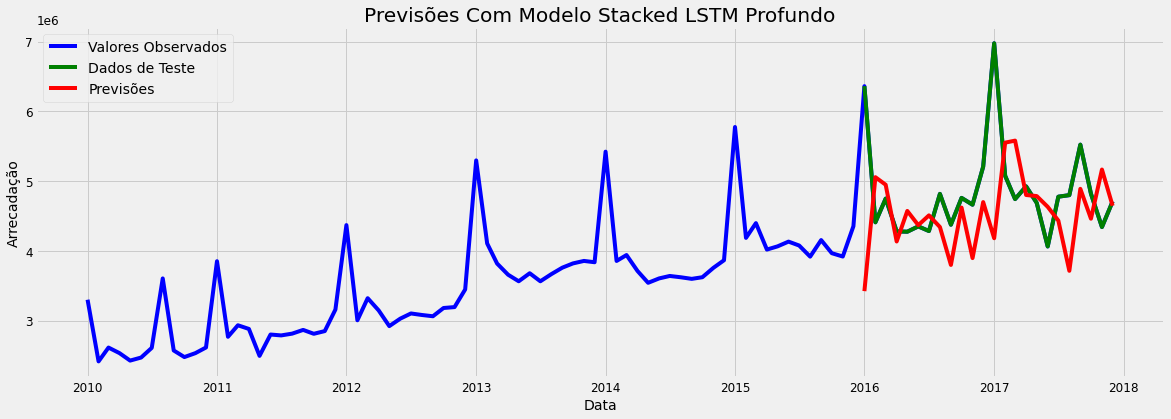

In [29]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(target[72:].index, previsoes_lstm, label = 'Previsões', color = 'Red')

plt.title('Previsões Com Modelo Stacked LSTM Profundo')
plt.xlabel('Data')
plt.ylabel('Arrecadação')
plt.legend(loc = 'upper left')
plt.show()


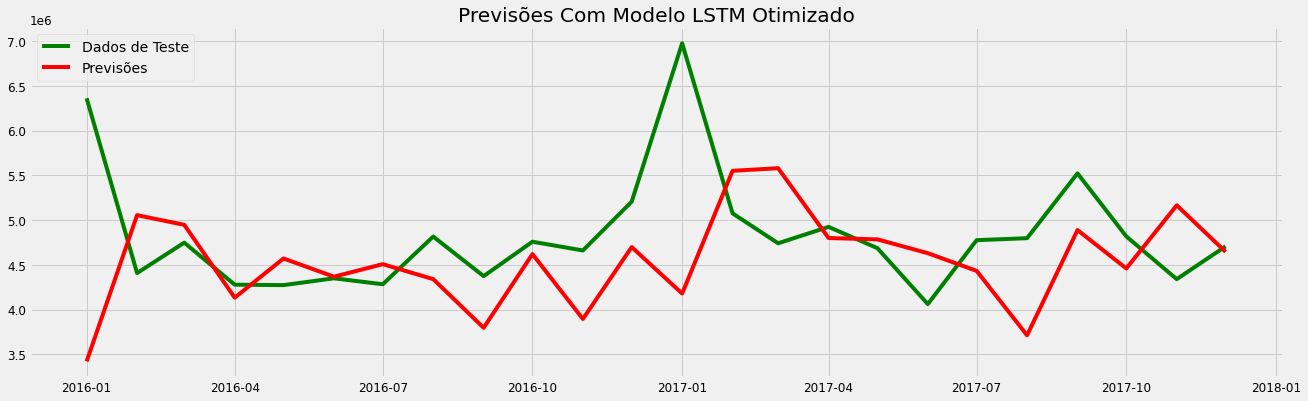

In [31]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(target[72:].index, previsoes_lstm, label = 'Previsões', color = 'Red')
plt.title('Previsões Com Modelo LSTM Otimizado')
plt.legend(loc = 'upper left')
plt.show()

Vamos fazer o Forecasting para 24 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [32]:
# Última data da série
target.index[-1]

Timestamp('2017-12-01 00:00:00')

In [33]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(months = x) for x in range(0, 25)]

In [34]:
# Visualiza as datas criadas
#datas_para_prever_forecasting

In [35]:
# Nossa série original é um objeto do tipo pd.Series
#type(arrecadacao_icms)

In [36]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [37]:
# Visualiza os dados
#df_original.head()

In [38]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [39]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
#data_futuras

In [40]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(previsoes_lstm,
                          index = data_futuras.index, columns = ['Prediction'])

In [41]:
# Concatenamos a série original com os valores de forecasting de 12 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [42]:
# Visualiza o dataframe
#df_forecasting

### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 24 meses que correspondem aos 24 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 24 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

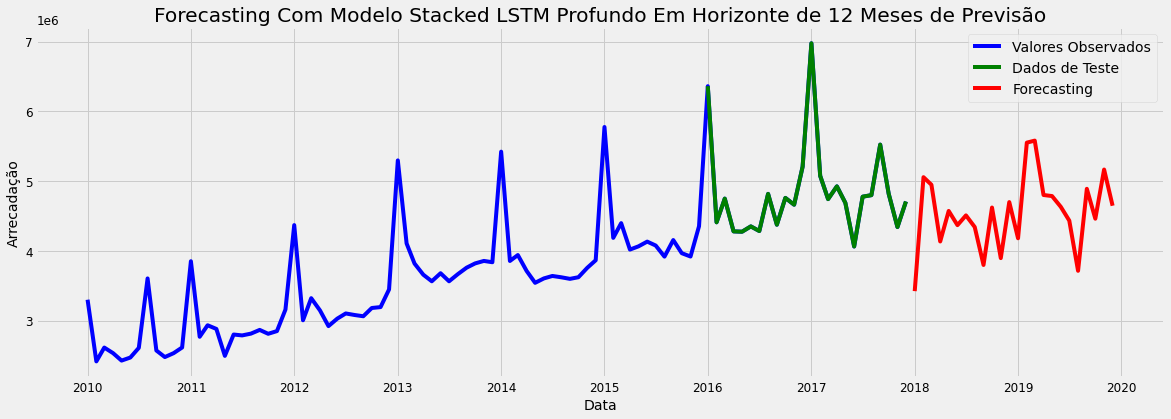

In [43]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo Stacked LSTM Profundo Em Horizonte de 12 Meses de Previsão')
plt.xlabel('Data')
plt.ylabel('Arrecadação')
plt.legend()
plt.show()

Graficamente o resultado não parece tão ruim, mas as métricas demonstram que esse modelo é o pior de todos, ainda possa até mesmo ser usado na falta de outra opção.

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (12,9) - AIC = 2044.48 e RMSE = 706415.3914
- Modelo 16 --> Modelo ARIMA (2,1,1) - AIC = 2106,43 e RMSE = 1099391.3958
- Modelo 17 --> Modelo SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC = 1251.06 e RMSE = 332666.2626
- Modelo 18 --> Modelo SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC = 1233.47 e RMSE = 336782.4202
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 15.8048 e RMSE = 1037107.0089   -   (5 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 11.7861 e RMSE = 878868.4191   -   (20 repetições)
- Modelo 23 --> Modelo Stacked LSTM - MAPE = 13.1198 e RMSE = 945778.1667
- Modelo 24 --> Modelo Stacked LSTM Profundo - MAPE = 12.3914 e RMSE = 877490,6632 

Mas.....ainda não fizemos otimização de hiperparâmetros do modelo! 

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim